#Bitcoin price prediction using Helformer Notebook 2 (Backtesting)

Based on Kehinde, T.O., Adedokun, O.J., Joseph, A. et al. Helformer: an attention-based deep learning model for cryptocurrency price forecasting. J Big Data 12, 81 (2025). https://doi.org/10.1186/s40537-025-01135-4

In this notebook we test the long-short strategy in the above paper using the model we trained in Notebook 1. The test period is 2023-01-01 to 2024-06-30.

In [1]:
# Model definition
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, initializers

# ---- HW: global seasonal template indexed by absolute phase ----
@tf.keras.utils.register_keras_serializable(package="Helformer")
class HoltWintersSmoothing(layers.Layer):
    """
    Learns global seasonal template S_k (k=0..m-1).
    Local level recursion L_t within each window:
        L_t = α * (X_t / S_{k_t}) + (1-α) L_{t-1}

    Outputs:
      y_norm   : (B,T,1)  = X_t / (S_{k_t} * L_t)
      base_next: (B,1)    = 1-step HW baseline forecast for next day
                           base_{t+1} = L_t_last * S_{k_{t_last}+1}
    """
    def __init__(self, m=365, alpha_init=0.2, eps=1e-6, **kw):
        super().__init__(**kw)
        self.m = int(m)
        self.alpha_init = float(alpha_init)
        self.eps = float(eps)

    def build(self, _):
        self.season_raw = self.add_weight(
            name="season_raw", shape=(self.m, 1),
            initializer=initializers.Zeros(),
            trainable=True, dtype=self.dtype
        )

        def inv_sigmoid(p):
            p = tf.clip_by_value(tf.constant(p, dtype=self.dtype), 1e-6, 1 - 1e-6)
            return tf.math.log(p) - tf.math.log(1 - p)

        self.alpha_raw = self.add_weight(
            name="alpha_raw", shape=(),
            initializer=initializers.Constant(inv_sigmoid(self.alpha_init)),
            trainable=True, dtype=self.dtype
        )
        super().build(_)

    @property
    def alpha(self):
        return tf.nn.sigmoid(self.alpha_raw)

    def get_config(self):
        cfg = super().get_config()
        cfg.update(dict(m=self.m, alpha_init=self.alpha_init, eps=self.eps))
        return cfg

    def call(self, inputs):
        x, phase = inputs  # x: (B,T,1), phase: (B,T)
        eps = tf.cast(self.eps, x.dtype)

        # seasonal template > 1
        season = 1.0 + tf.nn.softplus(self.season_raw)   # (m,1)

        # gather S_{k_t} for each timestep
        S = tf.gather(season[:, 0], phase)               # (B,T)
        S = tf.maximum(tf.expand_dims(S, -1), eps)       # (B,T,1)

        # init level
        x0 = tf.maximum(x[:, 0, :], eps)                 # (B,1)
        S0 = tf.maximum(S[:, 0, :], eps)                 # (B,1)
        L0 = tf.maximum(x0 / (S0 + eps), eps)            # (B,1)

        xT = tf.transpose(x, [1, 0, 2])                  # (T,B,1)
        ST = tf.transpose(S, [1, 0, 2])                  # (T,B,1)

        def level_step(L_prev, xs):
            x_t, S_t = xs
            L_t = self.alpha * (x_t / (S_t + eps)) + (1.0 - self.alpha) * L_prev
            return tf.maximum(L_t, eps)

        LT = tf.scan(level_step, (xT, ST), initializer=L0)  # (T,B,1)
        L  = tf.transpose(LT, [1, 0, 2])                    # (B,T,1)

        # normalized stream
        y_norm = x / (S * L + eps)                           # (B,T,1)

        # 1-step baseline forecast base_{t+1} = L_last * S_{k_next}
        phase_last = phase[:, -1]                            # (B,)
        phase_next = tf.math.floormod(phase_last + 1, self.m)
        S_next = tf.gather(season[:, 0], phase_next)         # (B,)
        S_next = tf.maximum(S_next, eps)
        L_last = L[:, -1, 0]                                 # (B,)
        base_next = tf.expand_dims(L_last * S_next, -1)      # (B,1)

        return y_norm, base_next


@tf.keras.utils.register_keras_serializable(package="Helformer")
class PhaseSinCos(layers.Layer):
    def __init__(self, m=365, **kw):
        super().__init__(**kw)
        self.m = int(m)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"m": self.m})
        return cfg

    def call(self, p_in):
        phase_f = tf.cast(p_in, tf.float32)
        ang = (2.0 * np.pi / float(self.m)) * phase_f
        sinp = tf.sin(ang)[..., None]
        cosp = tf.cos(ang)[..., None]
        return layers.Concatenate(axis=-1)([sinp, cosp])


@tf.keras.utils.register_keras_serializable(package="Helformer")
class HelformerBlock(layers.Layer):
    def __init__(self, d_model=64, heads=4, dropout=0.1, lstm_units=32, **kw):
        super().__init__(**kw)
        self.d_model = int(d_model)
        self.heads = int(heads)
        self.dropout = float(dropout)
        self.lstm_units = int(lstm_units)

        if self.d_model % self.heads != 0:
            raise ValueError(f"d_model ({self.d_model}) must be divisible by heads ({self.heads}).")

        self.mha  = layers.MultiHeadAttention(
            num_heads=self.heads,
            key_dim=self.d_model // self.heads,
            dropout=self.dropout
        )
        self.do1  = layers.Dropout(self.dropout)
        self.ln1  = layers.LayerNormalization(epsilon=1e-5)
        self.lstm = layers.LSTM(self.lstm_units, return_sequences=True)
        self.proj = layers.Dense(self.d_model)
        self.do2  = layers.Dropout(self.dropout)
        self.ln2  = layers.LayerNormalization(epsilon=1e-5)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "d_model": self.d_model,
            "heads": self.heads,
            "dropout": self.dropout,
            "lstm_units": self.lstm_units,
        })
        return cfg

    def call(self, x, training=False):
        attn = self.mha(x, x, use_causal_mask=True, training=training)
        x = self.ln1(x + self.do1(attn, training=training))
        y = self.proj(self.lstm(x, training=training))
        return self.ln2(x + self.do2(y, training=training))


def build_helformer(
    seq_len=30, d_model=64, heads=4, blocks=1, lstm_units=32,
    dropout=0.1, m=365, out_dim=1
):
    x_in = layers.Input(shape=(seq_len, 1), dtype=tf.float32, name="x")
    p_in = layers.Input(shape=(seq_len,), dtype=tf.int32, name="phase")

    # HW normalize + baseline for next day
    y_norm, base_next = HoltWintersSmoothing(m=m)([x_in, p_in])  # (B,T,1), (B,1)

    ph = PhaseSinCos(m=m)(p_in)                                  # (B,T,2)
    y  = layers.Concatenate(axis=-1)([y_norm, ph])               # (B,T,3)

    h = layers.Dense(d_model)(y)
    for _ in range(blocks):
        h = HelformerBlock(d_model, heads, dropout, lstm_units)(h)

    h = layers.LSTM(lstm_units, return_sequences=False)(h)

    # predict multiplicative residual multiplier (positive), then multiply back baseline
    # multiplier = exp(raw) keeps it > 0 and naturally centered near 1 when raw ~ 0
    raw = layers.Dense(out_dim)(h)                               # (B,1)
    mult = layers.Lambda(tf.exp, name="mult_exp")(raw)           # (B,1)
    out_price = layers.Multiply(name="price_hat")([mult, base_next])  # (B,1)

    return models.Model([x_in, p_in], out_price, name="Helformer")


# Before running the following cell, upload final_refit_model2.keras and price_scale_const.joblib on Github to the current directory of this notebook

In [2]:
# ======================================================
# LOAD MODEL2 (RAW-PRICE)
# Required in CURRENT DIRECTORY:
#   - final_refit_model2.keras
#   - price_scale_const.joblib
# ======================================================

import json, zipfile, shutil
from pathlib import Path
import joblib
import numpy as np

MODEL_PATH = Path("./final_refit_model2.keras")
SCALE_PATH = Path("./price_scale_const.joblib")

# ---- load constant scale ----
if not SCALE_PATH.exists():
    raise FileNotFoundError(f"Missing {SCALE_PATH.resolve()}")
PRICE_SCALE = float(joblib.load(str(SCALE_PATH)))
print("Loaded PRICE_SCALE =", PRICE_SCALE)

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Missing {MODEL_PATH.resolve()}")

# ------------------------------------------------------
# Helper: infer architecture from config.json inside .keras
# ------------------------------------------------------
def _get_model_cfg(cfg: dict) -> dict:
    # common nestings across keras versions
    if cfg.get("class_name") == "Functional" and "config" in cfg:
        return cfg
    if "model_config" in cfg and isinstance(cfg["model_config"], dict):
        return cfg["model_config"]
    # sometimes: {"class_name":"Model","config":{"model_config":{...}}}
    if "config" in cfg and isinstance(cfg["config"], dict) and "model_config" in cfg["config"]:
        return cfg["config"]["model_config"]
    return cfg

def infer_arch_from_keras(keras_path: Path) -> dict:
    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        if "config.json" not in names:
            raise RuntimeError("No config.json found inside .keras (unexpected).")
        cfg = json.loads(z.read("config.json").decode("utf-8"))

    cfg = _get_model_cfg(cfg)
    if cfg.get("class_name") != "Functional":
        raise RuntimeError(f"Expected Functional model config, got: {cfg.get('class_name')}")

    layers_cfg = cfg["config"]["layers"]
    out_layers = cfg["config"]["output_layers"]
    out_layer_name = out_layers[0][0]

    seq_len = None
    m_season = None
    blocks = 0
    d_model = None
    heads = None
    lstm_units = None
    dropout = None
    out_dim = None

    # infer seq_len from input layer named "x" if present; otherwise first InputLayer
    for layer in layers_cfg:
        cname = layer.get("class_name")
        lcfg = layer.get("config", {})
        lname = lcfg.get("name", "")

        if cname == "InputLayer" and (lname == "x" or seq_len is None):
            bs = lcfg.get("batch_shape") or lcfg.get("batch_input_shape")
            if bs and len(bs) >= 3 and bs[1] is not None:
                seq_len = int(bs[1])

        if cname == "HoltWintersSmoothing" and m_season is None:
            m_season = int(lcfg.get("m", 365))

        if cname == "HelformerBlock":
            blocks += 1
            # first block carries hyperparams in its config (because you implemented get_config)
            if d_model is None:
                d_model = int(lcfg["d_model"])
                heads = int(lcfg["heads"])
                lstm_units = int(lcfg["lstm_units"])
                dropout = float(lcfg["dropout"])

        if cname == "Dense" and lname == out_layer_name:
            out_dim = int(lcfg.get("units", 1))

    # fallbacks
    if seq_len is None:
        seq_len = 30
    if m_season is None:
        m_season = 365
    if out_dim is None:
        out_dim = 1

    if any(v is None for v in [d_model, heads, lstm_units, dropout]) or blocks == 0:
        raise RuntimeError(
            "Could not infer model hyperparams from config.json.\n"
            "This usually means the saved model does NOT contain HelformerBlock configs\n"
            "(e.g., you saved a different architecture than your current Step 3 code)."
        )

    return dict(
        seq_len=seq_len,
        m=m_season,
        blocks=blocks,
        d_model=d_model,
        heads=heads,
        lstm_units=lstm_units,
        dropout=dropout,
        out_dim=out_dim,
    )

# ------------------------------------------------------
# Helper: extract weights file from .keras zip
# ------------------------------------------------------
def extract_weights_from_keras(keras_path: Path, extract_dir: Path) -> Path:
    if extract_dir.exists():
        shutil.rmtree(extract_dir)
    extract_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(keras_path, "r") as z:
        names = z.namelist()
        # common name
        if "model.weights.h5" in names:
            wname = "model.weights.h5"
        else:
            cand = [n for n in names if n.endswith(".h5") and "weights" in n]
            if not cand:
                raise RuntimeError("No weights .h5 found inside .keras.")
            wname = sorted(cand, key=len)[0]
        z.extract(wname, path=extract_dir)

    return extract_dir / wname

# ------------------------------------------------------
# 1) Rebuild from saved config + load weights (no graph deserialization)
# ------------------------------------------------------
arch = infer_arch_from_keras(MODEL_PATH)
print("Inferred architecture from saved model:", arch)

weights_path = extract_weights_from_keras(MODEL_PATH, Path("./_extract_model2"))
print("Extracted weights:", weights_path)

model2 = build_helformer(
    seq_len=int(arch["seq_len"]),
    d_model=int(arch["d_model"]),
    heads=int(arch["heads"]),
    blocks=int(arch["blocks"]),
    lstm_units=int(arch["lstm_units"]),
    dropout=float(arch["dropout"]),
    m=int(arch["m"]),
    out_dim=int(arch["out_dim"]),
)

# IMPORTANT: load weights AFTER building the exact architecture
model2.load_weights(str(weights_path))
print("SUCCESS: model2 rebuilt + weights loaded.")

# ------------------------------------------------------
# Usage reminder:
# model2 outputs SCALED next-day price; multiply by PRICE_SCALE for USD
# ------------------------------------------------------
print("Model output: Pscaled_hat_{t+1}. Convert: Phat_usd = pred_scaled * PRICE_SCALE")




Loaded PRICE_SCALE = 8321.38134765625
Inferred architecture from saved model: {'seq_len': 30, 'm': 365, 'blocks': 2, 'd_model': 96, 'heads': 2, 'lstm_units': 40, 'dropout': 0.1893640156272847, 'out_dim': 1}
Extracted weights: _extract_model2/model.weights.h5
SUCCESS: model2 rebuilt + weights loaded.
Model output: Pscaled_hat_{t+1}. Convert: Phat_usd = pred_scaled * PRICE_SCALE


Strategy period: 2023-01-01 to 2024-06-30
Data after calendar align: (603, 1)
Predicting on 547 strategy samples...

STRATEGY PERFORMANCE (2023-01-01 to 2024-06-30)  [SIMPLE]
Decision days:        547
Z-Score Threshold:    0.0
--------------------------------------------------
Simple Total Return:  -18.84%
Annualized Return:    -1.64%
Annualized Vol:       39.88%
Simple Sharpe (252):  -0.04
Log Sharpe (252):     -0.24
Max Drawdown:         -45.76%
Total Turnover:       155.00



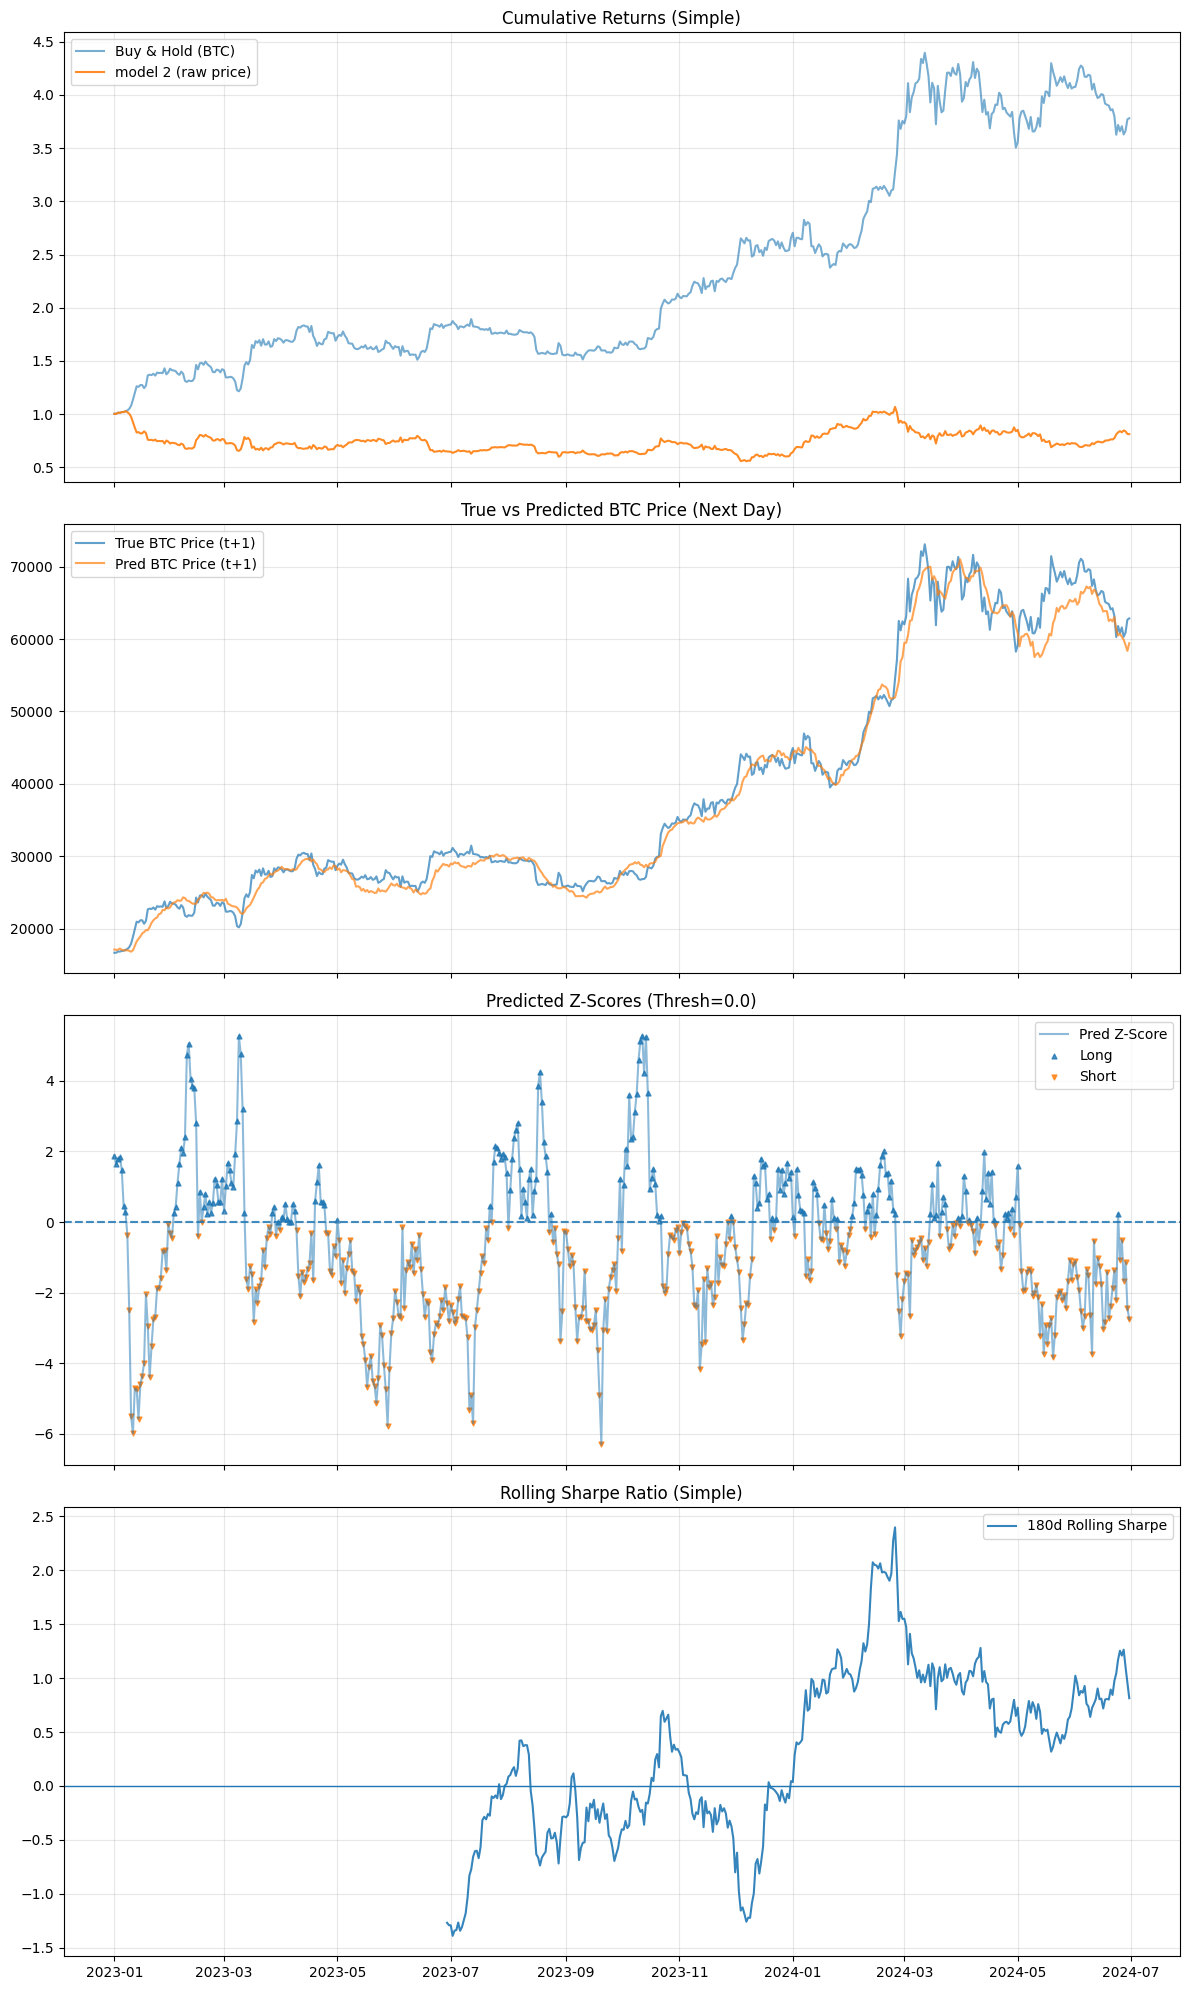

                 Price_t  Price_t_plus_1  Pred_Price_t_plus_1  \
2023-01-01  16625.080078    16688.470703         17135.021839   
2023-01-02  16688.470703    16679.857422         17075.093984   
2023-01-03  16679.857422    16863.238281         17101.010609   
2023-01-04  16863.238281    16836.736328         17280.183113   
2023-01-05  16836.736328    16951.968750         17075.429275   

            PredOverTrue_Rel  Pred_Return     Vol_t   Z_Score  Signal  \
2023-01-01          0.030673     0.030673  0.016283  1.883775       1   
2023-01-02          0.023167     0.023167  0.014138  1.638651       1   
2023-01-03          0.025249     0.025249  0.014103  1.790357       1   
2023-01-04          0.024725     0.024725  0.013427  1.841420       1   
2023-01-05          0.014177     0.014177  0.009602  1.476428       1   

            Strat_Net  
2023-01-01   0.002813  
2023-01-02  -0.000516  
2023-01-03   0.010994  
2023-01-04  -0.001572  
2023-01-05   0.006844  
                 Price_t  

In [16]:
# ======================================================
# VOLATILITY-ADJUSTED STRATEGY (BTC ONLY)
# ======================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# ---------------- Configuration ----------------
SEQ_LEN      = 30 # Lookback window
M_SEASON     = 365
FORECAST_HOR = 1   # predict next-day price

START = "2023-01-01"
END   = "2024-06-30"

VOL_WINDOW   = 20  # Window for computing rolling volatility
Z_THRESHOLD  = 0.0 # This is the same as the strategy used in the paper
FEE          = 0.001 # 0.01% transaction fee
ROLLING_SHARPE_WIN = 180 # Window for computing rolling SR
ANN = 252

# ---------------- 1. Download with START-SEQ_LEN buffer ----------------
START_TS = pd.Timestamp(START)
END_TS   = pd.Timestamp(END)

DOWNLOAD_START = (START_TS - pd.Timedelta(days=SEQ_LEN + VOL_WINDOW + 5)).strftime("%Y-%m-%d")
DOWNLOAD_END   = (END_TS + pd.Timedelta(days=2)).strftime("%Y-%m-%d")  # need t+1 realized

print(f"Strategy period: {START} to {END}")
print(f"Downloading BTC-USD from {DOWNLOAD_START} to {DOWNLOAD_END}...")

raw = yf.download(
    tickers="BTC-USD",
    start=DOWNLOAD_START,
    end=DOWNLOAD_END,
    interval="1d",
    auto_adjust=True,
    progress=False
)
if raw.empty:
    raise ValueError("No data downloaded. Check your internet or date range.")

# Flatten columns if MultiIndex
if isinstance(raw.columns, pd.MultiIndex):
    # yfinance sometimes returns MultiIndex
    if ("Close" in raw.columns.get_level_values(-1)):
        data = raw.xs("Close", level=-1, axis=1).copy()
        if data.shape[1] > 1:
            data = data.iloc[:, [0]]
        data.columns = ["BTC"]
    else:
        data = raw[["Close"]].copy()
        data.columns = ["BTC"]
else:
    data = raw[["Close"]].rename(columns={"Close": "BTC"})

data["BTC"] = data["BTC"].astype(np.float64)

# ---------------- 2. Calendar alignment ----------------
full_idx = pd.date_range(start=data.index.min(), end=data.index.max(), freq="D")
data = data.reindex(full_idx).ffill()
data.index.name = "Date"
print("Data after calendar align:", data.shape)

# ---------------- 3. Build features for RAW PRICE model ----------------
data["Ret_Simple"] = data["BTC"].pct_change()

# constant scaling for model input (no shift)
data["Price_Scaled"] = (data["BTC"] / PRICE_SCALE).astype(np.float32)

# ---------------- 4. Phase calculation ----------------
EPOCH = pd.Timestamp("2017-01-01")
days = (data.index.normalize() - EPOCH).days.astype(int)
data["phase"] = (days % M_SEASON).astype(np.int32)

# ---------------- 5. Volatility known at time t (decision time) ----------------
data["Vol_t"] = data["Ret_Simple"].rolling(VOL_WINDOW).std()

# ---------------- 6. Windowing: create samples indexed by decision day t ----------------
val_arr   = data["Price_Scaled"].values.astype(np.float32)
phase_arr = data["phase"].values.astype(np.int32)
price_arr = data["BTC"].values.astype(np.float64)
vol_arr   = data["Vol_t"].values.astype(np.float64)
idx_arr   = data.index

X_test, P_test = [], []
dec_dates = []
P_t = []
P_t1 = []
Vol_t = []

# We predict P_{t+1} using window ending at t (index i),
# and evaluate using realized price at t+1 (i+1).
for i in range(SEQ_LEN - 1, len(data) - 1):
    decision_date = idx_arr[i]
    next_date     = idx_arr[i + 1]

    if not (START_TS <= decision_date <= END_TS):
        continue

    if not np.isfinite(vol_arr[i]):
        continue

    X_test.append(val_arr[i-SEQ_LEN+1:i+1].reshape(SEQ_LEN, 1))
    P_test.append(phase_arr[i-SEQ_LEN+1:i+1])

    dec_dates.append(decision_date)
    P_t.append(price_arr[i])
    P_t1.append(price_arr[i + 1])
    Vol_t.append(vol_arr[i])

if len(X_test) == 0:
    raise RuntimeError("No strategy samples produced. Check date range and data availability.")

X_test = np.array(X_test, dtype=np.float32)
P_test = np.array(P_test, dtype=np.int32)

P_t   = np.asarray(P_t, dtype=np.float64)
P_t1  = np.asarray(P_t1, dtype=np.float64)
Vol_t = np.asarray(Vol_t, dtype=np.float64)

# ---------------- 7. Predict next-day PRICES (scaled), then invert to USD ----------------
print(f"Predicting on {len(X_test)} strategy samples...")
pred_scaled = model2.predict([X_test, P_test], batch_size=512, verbose=0)
pred_scaled = np.asarray(pred_scaled).reshape(-1).astype(np.float64)

P_hat_t1 = pred_scaled * PRICE_SCALE   # back to USD

# Predicted simple return implied by predicted price
pred_simple_ret = (P_hat_t1 / P_t) - 1.0

# ---------------- 8. Build results DF (indexed by decision day t) ----------------
df_res = pd.DataFrame(index=pd.DatetimeIndex(dec_dates))
df_res["Price_t"] = P_t
df_res["Price_t_plus_1"] = P_t1
df_res["Pred_Price_t_plus_1"] = P_hat_t1

df_res["Pred_Return"] = pred_simple_ret
df_res["Actual_Return"] = (df_res["Price_t_plus_1"] / df_res["Price_t"]) - 1.0
df_res["Vol_t"] = Vol_t

# Requested plots
df_res["PredOverTrue_Rel"]    = (df_res["Pred_Price_t_plus_1"] / df_res["Price_t"]) - 1.0

# ---------------- 9. Z-score + Signal ----------------
df_res["Z_Score"] = df_res["Pred_Return"] / df_res["Vol_t"]

df_res["Signal"] = np.where(
    df_res["Z_Score"] > Z_THRESHOLD, 1,
    np.where(df_res["Z_Score"] < -Z_THRESHOLD, -1, 0)
).astype(int)

# ---------------- 10. Simple PnL + Fees (no lookahead) ----------------
sig = df_res["Signal"].values.astype(np.float64)
prev = np.r_[0.0, sig[:-1]]
turnover = np.abs(sig - prev)

gross = sig * df_res["Actual_Return"].values.astype(np.float64)
net = gross - turnover * FEE

df_res["Turnover"] = turnover
df_res["Strat_Gross"] = gross
df_res["Strat_Net"] = net

df_res["Cum_BnH"] = (1.0 + df_res["Actual_Return"]).cumprod()
df_res["Cum_Strat"] = (1.0 + df_res["Strat_Net"]).cumprod()

# ---------------- 11. Metrics ----------------
simple_total_return = float(df_res["Cum_Strat"].iloc[-1] - 1.0)

annualized_ret = float(df_res["Strat_Net"].mean() * ANN)
annualized_vol = float(df_res["Strat_Net"].std(ddof=0) * np.sqrt(ANN))
simple_sharpe  = float((annualized_ret / annualized_vol)) if annualized_vol != 0 else 0.0

max_drawdown = float((df_res["Cum_Strat"] / df_res["Cum_Strat"].cummax() - 1.0).min())

# Log Sharpe (on portfolio log returns)
if (df_res["Strat_Net"] <= -1.0).any():
    log_sharpe = np.nan
else:
    strat_log = np.log1p(df_res["Strat_Net"].astype(np.float64))
    log_ann_ret = float(strat_log.mean() * ANN)
    log_ann_vol = float(strat_log.std(ddof=0) * np.sqrt(ANN))
    log_sharpe = float(log_ann_ret / log_ann_vol) if log_ann_vol != 0 else 0.0

df_res["Rolling_Sharpe"] = (
    df_res["Strat_Net"].rolling(ROLLING_SHARPE_WIN).mean() /
    df_res["Strat_Net"].rolling(ROLLING_SHARPE_WIN).std(ddof=0)
) * np.sqrt(ANN)

print("\n" + "="*50)
print(f"STRATEGY PERFORMANCE ({START} to {END})  [SIMPLE]")
print(f"Decision days:        {len(df_res)}")
print(f"Z-Score Threshold:    {Z_THRESHOLD}")
print("-"*50)
print(f"Simple Total Return:  {simple_total_return*100:.2f}%")
print(f"Annualized Return:    {annualized_ret*100:.2f}%")
print(f"Annualized Vol:       {annualized_vol*100:.2f}%")
print(f"Simple Sharpe (252):  {simple_sharpe:.2f}")
print(f"Log Sharpe (252):     {log_sharpe:.2f}")
print(f"Max Drawdown:         {max_drawdown*100:.2f}%")
print(f"Total Turnover:       {df_res['Turnover'].sum():.2f}")
print("="*50 + "\n")

# ---------------- 12. Plotting ----------------
fig, axes = plt.subplots(4, 1, figsize=(12, 20), sharex=True)

# (0) Cumulative
axes[0].plot(df_res.index, df_res["Cum_BnH"], label="Buy & Hold (BTC)", alpha=0.6)
axes[0].plot(df_res.index, df_res["Cum_Strat"], label="model 2 (raw price)", alpha=0.9)
axes[0].set_title("Cumulative Returns (Simple)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (1) True vs predicted price (t+1)
axes[1].plot(df_res.index, df_res["Price_t_plus_1"], label="True BTC Price (t+1)", alpha=0.7)
axes[1].plot(df_res.index, df_res["Pred_Price_t_plus_1"], label="Pred BTC Price (t+1)", alpha=0.7)
axes[1].set_title("True vs Predicted BTC Price (Next Day)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# (2) Z-score + entries
axes[2].plot(df_res.index, df_res["Z_Score"], label="Pred Z-Score", alpha=0.5)
axes[2].axhline(Z_THRESHOLD, linestyle="--", alpha=0.6)
axes[2].axhline(-Z_THRESHOLD, linestyle="--", alpha=0.6)
longs = df_res[df_res["Signal"] == 1]
shorts = df_res[df_res["Signal"] == -1]
axes[2].scatter(longs.index, longs["Z_Score"], marker="^", s=12, label="Long", alpha=0.8)
axes[2].scatter(shorts.index, shorts["Z_Score"], marker="v", s=12, label="Short", alpha=0.8)
axes[2].set_title(f"Predicted Z-Scores (Thresh={Z_THRESHOLD})")
axes[2].legend(loc="upper right")
axes[2].grid(True, alpha=0.3)

# (3) Rolling Sharpe
axes[3].plot(df_res.index, df_res["Rolling_Sharpe"], label=f"{ROLLING_SHARPE_WIN}d Rolling Sharpe", alpha=0.9)
axes[3].axhline(0.0, linestyle="-", linewidth=1)
axes[3].set_title("Rolling Sharpe Ratio (Simple)")
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------- 13. Quick head and tail ----------------
display_cols = [
    "Price_t", "Price_t_plus_1", "Pred_Price_t_plus_1", "PredOverTrue_Rel",
    "Pred_Return", "Vol_t", "Z_Score", "Signal", "Strat_Net"
]
print(df_res[display_cols].head(5))
print(df_res[display_cols].tail(5))



# Diagnosis

In [4]:
import numpy as np

df = df_res.copy()

# realized and predicted next-day returns
df["r"]    = df["Price_t_plus_1"] / df["Price_t"] - 1.0
df["rhat"] = df["Pred_Price_t_plus_1"] / df["Price_t"] - 1.0

# true forecast error (THIS is the error, not Phat - Pt)
df["err_price"] = df["Pred_Price_t_plus_1"] - df["Price_t_plus_1"]
df["err_ret"]   = df["rhat"] - df["r"]

# basic stats
corr = float(np.corrcoef(df["rhat"], df["r"])[0, 1])
hit  = float((np.sign(df["rhat"]) == np.sign(df["r"])).mean())
mean_rhat = float(df["rhat"].mean())
mean_r    = float(df["r"].mean())

# regression slope r ≈ a + b rhat  (b<0 => you are anti-predicting)
x = df["rhat"].values
y = df["r"].values
b = float(np.cov(x, y, ddof=0)[0, 1] / (np.var(x) + 1e-12))

print("corr(rhat, r)        =", corr)
print("direction hit-rate   =", hit)
print("mean(rhat)           =", mean_rhat)
print("mean(r)              =", mean_r)
print("regression slope b   =", b, "   (b<0 means flip sign helps)")

# compare vs dumb baseline Phat_{t+1}=P_t  -> rhat=0
mse_ret_model = float(np.mean(df["err_ret"]**2))
mse_ret_rw    = float(np.mean((0.0 - df["r"])**2))
print("MSE on returns: model =", mse_ret_model, "   RW baseline =", mse_ret_rw)

# what your sign strategy is actually doing (gross; no fees)
sig = np.sign(df["rhat"].values).astype(float)
gross = sig * df["r"].values
gross_flip = (-sig) * df["r"].values
print("Mean gross (sign)        =", float(gross.mean()))
print("Mean gross (flip sign)   =", float(gross_flip.mean()))

# turnover diagnostic (fees amplify this)
turnover = np.mean(np.abs(sig[1:] - sig[:-1]))
print("Avg turnover per day (sign flips) =", float(turnover))
print("Frac long =", float((sig > 0).mean()), "Frac short =", float((sig < 0).mean()), "Frac flat =", float((sig == 0).mean()))


corr(rhat, r)        = 0.059737926964153865
direction hit-rate   = 0.5173674588665448
mean(rhat)           = -0.015824613221074833
mean(r)              = 0.002742484528334299
regression slope b   = 0.03771495929561042    (b<0 means flip sign helps)
MSE on returns: model = 0.002414157112714421    RW baseline = 0.0006309158615754461
Mean gross (sign)        = 0.0002182666001267426
Mean gross (flip sign)   = -0.0002182666001267426
Avg turnover per day (sign flips) = 0.28205128205128205
Frac long = 0.360146252285192 Frac short = 0.6398537477148081 Frac flat = 0.0


In [5]:
import numpy as np
import pandas as pd

# ---- config ----
ANN = 252
FEE = 0.001     # transaction fee
SPLIT_DATE = "2024-01-01"  # choose a real holdout boundary

df = df_res.copy().sort_index()
df["r"]    = df["Price_t_plus_1"] / df["Price_t"] - 1.0
df["rhat"] = df["Pred_Price_t_plus_1"] / df["Price_t"] - 1.0

calib = df.loc[:pd.Timestamp(SPLIT_DATE) - pd.Timedelta(days=1)].copy()
test  = df.loc[pd.Timestamp(SPLIT_DATE):].copy()

print("calib:", calib.index.min(), "->", calib.index.max(), "n=", len(calib))
print("test :", test.index.min(),  "->", test.index.max(),  "n=", len(test))

# -------------------------
# helpers
# -------------------------
def fit_linear_calibration(rhat, r):
    # fit r ≈ a + b rhat on calibration
    x = np.asarray(rhat, dtype=float)
    y = np.asarray(r, dtype=float)
    X = np.column_stack([np.ones_like(x), x])
    a, b = np.linalg.lstsq(X, y, rcond=None)[0]
    return float(a), float(b)

def apply_strategy(r, rhat_used, tau):
    # signal: sign(rhat_used) if |rhat_used|>tau else 0
    r = np.asarray(r, dtype=float)
    s = np.where(np.abs(rhat_used) > tau, np.sign(rhat_used), 0.0)

    prev = np.r_[0.0, s[:-1]]
    turnover = np.abs(s - prev)

    gross = s * r
    net = gross - turnover * FEE

    cum = np.cumprod(1.0 + net)
    mdd = float((cum / np.maximum.accumulate(cum) - 1.0).min())

    ann_ret = float(net.mean() * ANN)
    ann_vol = float(net.std(ddof=0) * np.sqrt(ANN))
    sharpe  = float(ann_ret / ann_vol) if ann_vol > 0 else 0.0

    return {
        "active_frac": float(np.mean(s != 0)),
        "turnover_avg": float(np.mean(turnover)),
        "ann_ret": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "mdd": mdd,
        "cum_end": float(cum[-1]),
    }

# -------------------------
# 1) Fit calibration mapping r ≈ a + b rhat
# -------------------------
a, b = fit_linear_calibration(calib["rhat"], calib["r"])
print(f"Linear calibration on CALIB: r ≈ a + b rhat with a={a:.6g}, b={b:.6g}")

calib["rhat_cal"] = a + b * calib["rhat"]
test["rhat_cal"]  = a + b * test["rhat"]

# -------------------------
# 2) Search tau on calibration, evaluate on test
# -------------------------
taus = np.linspace(0.0, 0.02, 41)

rows = []
for tau in taus:
    m_cal = apply_strategy(calib["r"].values, calib["rhat_cal"].values, tau)
    m_tst = apply_strategy(test["r"].values,  test["rhat_cal"].values,  tau)
    rows.append({
        "tau": float(tau),
        "cal_sharpe": m_cal["sharpe"],
        "cal_ann_ret": m_cal["ann_ret"],
        "cal_turnover": m_cal["turnover_avg"],
        "cal_active": m_cal["active_frac"],
        "test_sharpe": m_tst["sharpe"],
        "test_ann_ret": m_tst["ann_ret"],
        "test_turnover": m_tst["turnover_avg"],
        "test_active": m_tst["active_frac"],
    })

res = pd.DataFrame(rows).sort_values("cal_sharpe", ascending=False)
best = res.iloc[0]
print("\nBest tau chosen on CALIB (by Sharpe):")
print(best)

print("\nTop 10 candidates (chosen on CALIB):")
print(res.head(10))

# -------------------------
# 3) Report the OOS performance at chosen tau
# -------------------------
tau_star = float(best["tau"])
m_cal_star = apply_strategy(calib["r"].values, calib["rhat_cal"].values, tau_star)
m_tst_star = apply_strategy(test["r"].values,  test["rhat_cal"].values,  tau_star)

print("\n===== FINAL (Calib-chosen tau) =====")
print(f"tau* = {tau_star:.4f}")
print("CALIB:", m_cal_star)
print("TEST :", m_tst_star)


calib: 2023-01-01 00:00:00 -> 2023-12-31 00:00:00 n= 365
test : 2024-01-01 00:00:00 -> 2024-06-30 00:00:00 n= 182
Linear calibration on CALIB: r ≈ a + b rhat with a=0.00311068, b=0.0111936

Best tau chosen on CALIB (by Sharpe):
tau              0.002000
cal_sharpe       2.056285
cal_ann_ret      0.749119
cal_turnover     0.024658
cal_active       0.989041
test_sharpe      1.441341
test_ann_ret     0.650549
test_turnover    0.038462
test_active      0.978022
Name: 4, dtype: float64

Top 10 candidates (chosen on CALIB):
      tau  cal_sharpe  cal_ann_ret  cal_turnover  cal_active  test_sharpe  \
4  0.0020    2.056285     0.749119      0.024658    0.989041     1.441341   
0  0.0000    2.029422     0.740400      0.002740    1.000000     1.301591   
1  0.0005    2.029422     0.740400      0.002740    1.000000     1.301591   
2  0.0010    2.029422     0.740400      0.002740    1.000000     1.301591   
3  0.0015    2.029422     0.740400      0.002740    1.000000     1.301591   
5  0.0025    1

In [6]:
import numpy as np

def report_exposure_and_bnh(df_block, rhat_used, name="BLOCK"):
    r = df_block["Price_t_plus_1"].values / df_block["Price_t"].values - 1.0
    sig = np.where(np.abs(rhat_used) > tau_star, np.sign(rhat_used), 0.0)

    # fees
    prev = np.r_[0.0, sig[:-1]]
    turnover = np.abs(sig - prev)
    net = sig * r - turnover * FEE

    cum_strat = np.cumprod(1.0 + net)
    cum_bnh   = np.cumprod(1.0 + r)

    print(f"\n=== {name} ===")
    print("frac long =", float((sig > 0).mean()),
          "frac short =", float((sig < 0).mean()),
          "frac flat =", float((sig == 0).mean()))
    print("avg position =", float(sig.mean()), "(~1 means basically always long)")
    print("cum_end strat =", float(cum_strat[-1]), "cum_end BnH =", float(cum_bnh[-1]))
    print("corr(strat_ret, bnh_ret) =", float(np.corrcoef(net, r)[0,1]))

# Use your existing objects from the previous cell:
# calib, test, tau_star, FEE

# calibrated forecasts
rhat_cal_calib = calib["rhat_cal"].values
rhat_cal_test  = test["rhat_cal"].values

report_exposure_and_bnh(calib, rhat_cal_calib, name="CALIB")
report_exposure_and_bnh(test,  rhat_cal_test,  name="TEST")



=== CALIB ===
frac long = 0.989041095890411 frac short = 0.0 frac flat = 0.010958904109589041
avg position = 0.989041095890411 (~1 means basically always long)
cum_end strat = 2.6883956485765412 cum_end BnH = 2.656668829485194
corr(strat_ret, bnh_ret) = 0.999217673126303

=== TEST ===
frac long = 0.978021978021978 frac short = 0.0 frac flat = 0.02197802197802198
avg position = 0.978021978021978 (~1 means basically always long)
cum_end strat = 1.4863434241411955 cum_end BnH = 1.42304227079598
corr(strat_ret, bnh_ret) = 0.9975721774890376


In [7]:
import numpy as np

# realized BH return each day
r = test["Price_t_plus_1"].values / test["Price_t"].values - 1.0

# your strategy net return each day (recompute from your signal)
sig = np.where(np.abs(test["rhat_cal"].values) > tau_star, np.sign(test["rhat_cal"].values), 0.0)
prev = np.r_[0.0, sig[:-1]]
turnover = np.abs(sig - prev)
strat = sig * r - turnover * FEE

active = strat - r  # strategy minus BH

ANN = 252
def sharpe(x):
    vol = x.std(ddof=0)
    return (x.mean() / vol) * np.sqrt(ANN) if vol > 0 else 0.0

print("TEST corr(strat, BH) =", float(np.corrcoef(strat, r)[0,1]))
print("TEST mean active/day =", float(active.mean()))
print("TEST ann active ret  =", float(active.mean()*ANN))
print("TEST ann active vol  =", float(active.std(ddof=0)*np.sqrt(ANN)))
print("TEST active Sharpe   =", float(sharpe(active)))
print("TEST active hit-rate =", float((active > 0).mean()))


TEST corr(strat, BH) = 0.9975721774890376
TEST mean active/day = 0.00023685323769658245
TEST ann active ret  = 0.05968701589953877
TEST ann active vol  = 0.031546293891336785
TEST active Sharpe   = 1.8920452622781776
TEST active hit-rate = 0.02197802197802198
